<h4> Import Libraries

In [26]:
import numpy as np, pandas as pd, re
# Libraries for text preprocessing
import re, nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
# nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

# Libraries for WordCloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import coo_matrix

<h4> User Defined Function

In [6]:
def lemmatise(text, stop_word_list):
    
    # Convert to list from string
    text = text.split()
    
    # Stemming
    ps = PorterStemmer()
    
    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_word_list] 
    text = " ".join(text)
    
    return(text)

<h4> Data Import

In [25]:
# Import Reviews Data
music_df = pd.read_csv('reviews.csv')
music_df = music_df.loc[music_df['score'] > 7.4]
music_df = music_df[['reviewid','title','url','content','genre','artist','label']]

# Remove Missing Values
music_df['content'].fillna('', inplace=True)

# Data Preview
print(f'Data Shape: {music_df.shape}')
music_df.head()

Data Shape: (7635, 7)


,reviewid,title,url,content,genre,artist,label
0,22703,mezzanine,http://pitchfork.com/reviews/albums/22703-mezz...,"“Trip-hop” eventually became a ’90s punchline,...",electronic,massive attack,virgin
1,22721,prelapsarian,http://pitchfork.com/reviews/albums/22721-prel...,"Eight years, five albums, and two EPs in, the ...",metal,krallice,hathenter
3,22661,first songs,http://pitchfork.com/reviews/albums/22661-firs...,Kleenex began with a crash. It transpired one ...,rock,"kleenex, liliput",kill rock stars
4,22725,new start,http://pitchfork.com/reviews/albums/22725-new-...,It is impossible to consider a given release b...,electronic,taso,teklife
8,22714,reflection,http://pitchfork.com/reviews/albums/22714-refl...,Ambient music is a funny thing. As innocuous a...,experimental,brian eno,warp


#### <h4> Preliminary Data Exploration

In [4]:
# Fetch wordcount for each Review
music_df['word_count'] = music_df['content'].apply(lambda x: len(str(x).split(" ")))
music_df[['content', 'word_count']].head()

,content,word_count
0,"“Trip-hop” eventually became a ’90s punchline,...",1432
1,"Eight years, five albums, and two EPs in, the ...",416
3,Kleenex began with a crash. It transpired one ...,1155
4,It is impossible to consider a given release b...,526
8,Ambient music is a funny thing. As innocuous a...,690


In [5]:
# Descriptive statistics of word counts
music_df['word_count'].describe()

count    7635.000000
mean      775.095874
std       299.346103
min         1.000000
25%       573.000000
50%       713.000000
75%       903.000000
max      3678.000000
Name: word_count, dtype: float64

In [6]:
# Identify common words
pd.Series(' '.join(music_df['content']).split()).value_counts()[:20]

the      264603
of       167607
and      155309
a        147709
to       108773
in        70773
that      57357
is        54604
with      48748
on        45356
as        43425
for       34876
his       29645
The       28858
it        28777
but       25898
from      25834
like      25044
an        24296
their     22005
dtype: int64

In [7]:
# Identify uncommon words
pd.Series(' '.join(music_df['content']).split()).value_counts()[-20:]

black.With           1
Daughn               1
cigarette-smoke      1
brave.All            1
unfolds--            1
awakening.Another    1
Lou",                1
washed-up,           1
"died                1
"Ray",               1
worthless."As        1
re-imagines,         1
candyfloss:          1
bedroom."            1
stools.All           1
lassoing             1
ask-a-punk           1
quasi-legal          1
Minutemen.Quite      1
equity!              1
dtype: int64

<h4> Text Pre-processing

In [8]:
# Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))

# Creating a list of custom stopwords
new_words = ['using', 'also', 'one', 'two', 'previously', 'year', 'get', 'still', 'could', 'thing', 'take', 'back', 'would', 'minute', 'might', 'go']
# stop_words = stop_words.union(new_words)

In [9]:
# Noise Removal
music_df['content_processed'] = music_df['content'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))                               # Remove Punctuations
music_df['content_processed'] = music_df['content_processed'].str.lower()                                                      # Convert to Lowercase
music_df['content_processed'] = music_df['content_processed'].apply(lambda x: re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", x))         # Remove tags
music_df['content_processed'] = music_df['content_processed'].apply(lambda x: re.sub("(\\d|\\W)+"," ", x))                     # Remove Special Characters and Digits
music_df['content_processed'] = music_df['content_processed'].apply(lambda x: lemmatise(x, stop_words))                        # Lemmatisation
music_df['content_processed'] = music_df['content_processed'].replace(r"^ +| +$", r"", regex=True)                             # Remove Leading and Trailing Blanks

music_df

,reviewid,title,url,content,genre,artist,label,word_count,content_processed
0,22703,mezzanine,http://pitchfork.com/reviews/albums/22703-mezz...,"“Trip-hop” eventually became a ’90s punchline,...",electronic,massive attack,virgin,1432,trip hop eventually became punchline music pre...
1,22721,prelapsarian,http://pitchfork.com/reviews/albums/22721-prel...,"Eight years, five albums, and two EPs in, the ...",metal,krallice,hathenter,416,eight year five album two eps new york based o...
3,22661,first songs,http://pitchfork.com/reviews/albums/22661-firs...,Kleenex began with a crash. It transpired one ...,rock,"kleenex, liliput",kill rock stars,1155,kleenex began crash transpired one night long ...
4,22725,new start,http://pitchfork.com/reviews/albums/22725-new-...,It is impossible to consider a given release b...,electronic,taso,teklife,526,impossible consider given release footwork art...
8,22714,reflection,http://pitchfork.com/reviews/albums/22714-refl...,Ambient music is a funny thing. As innocuous a...,experimental,brian eno,warp,690,ambient music funny thing innocuous may seem s...
...,...,...,...,...,...,...,...,...,...
18377,1023,mission: control!,http://pitchfork.com/reviews/albums/1023-missi...,The ripples from Jawbox's dive into the underg...,rock,burning airlines,desoto,1118,ripple jawbox dive underground rock pond still...
18378,287,all-in,http://pitchfork.com/reviews/albums/287-all-in/,I got a heart so big it could crush this town....,pop/r&b,arling and cameron,emperor norton,635,got heart big could crush town really swiping ...
18380,6455,sam prekop,http://pitchfork.com/reviews/albums/6455-sam-p...,"I'm psyched. Y'know why? Okay, okay, if you'...",electronic,sam prekop,thrill jockey,609,psyched know okay okay gonna drag guess tell m...
18381,361,peel session,http://pitchfork.com/reviews/albums/361-peel-s...,"If you know 'em, maybe you love 'em. They're ...",electronic,autechre,interscope,592,know em maybe love em autechre folk sean booth...


<h4> WordCloud

In [10]:
corpus = music_df['content_processed'].tolist()

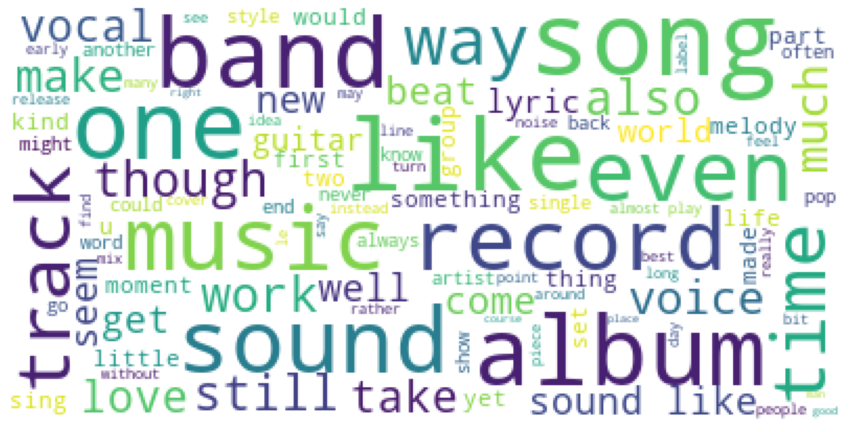

In [11]:
%matplotlib inline
wordcloud = WordCloud(background_color='white',
                      stopwords=stop_words,
                      max_words=100,
                      max_font_size=50,
                      random_state=42).generate(str(corpus))

print(wordcloud)  # WordCloud for top 100 words under content_processed 

fig = plt.figure(figsize=(15, 9))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

<h4> Text Preparation

In [12]:
cv = CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,2))
X = cv.fit_transform(corpus)

In [13]:
list(cv.vocabulary_.keys())[:10]

['trip',
 'hop',
 'eventually',
 'became',
 'punchline',
 'music',
 'press',
 'shorthand',
 'hotel',
 'lounge']

<h4> Convert to Matrix of Integers

In [14]:
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)

# get feature names
feature_names = cv.get_feature_names()

In [15]:
# Function for sorting tf_idf in descending order
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=20):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [16]:
def get_keywords(doc):
    
    # Generate tf-idf for the given document
    tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))

    # Sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    # Extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,15)
    
    return(list(keywords.keys()))

In [17]:
music_df['keywords'] = music_df['content_processed'].apply(get_keywords) 
music_df

,reviewid,title,url,content,genre,artist,label,word_count,content_processed,keywords
0,22703,mezzanine,http://pitchfork.com/reviews/albums/22703-mezz...,"“Trip-hop” eventually became a ’90s punchline,...",electronic,massive attack,virgin,1432,trip hop eventually became punchline music pre...,"[massive attack, del, attack, massive, andy, a..."
1,22721,prelapsarian,http://pitchfork.com/reviews/albums/22721-prel...,"Eight years, five albums, and two EPs in, the ...",metal,krallice,hathenter,416,eight year five album two eps new york based o...,"[krallice, humanity, clock, winter, shared, la..."
3,22661,first songs,http://pitchfork.com/reviews/albums/22661-firs...,Kleenex began with a crash. It transpired one ...,rock,"kleenex, liliput",kill rock stars,1155,kleenex began crash transpired one night long ...,"[woo, punk, la la, madness, la, trade, rough, ..."
4,22725,new start,http://pitchfork.com/reviews/albums/22725-new-...,It is impossible to consider a given release b...,electronic,taso,teklife,526,impossible consider given release footwork art...,"[footwork, cup, rashad, double, earl, producer..."
8,22714,reflection,http://pitchfork.com/reviews/albums/22714-refl...,Ambient music is a funny thing. As innocuous a...,experimental,brian eno,warp,690,ambient music funny thing innocuous may seem s...,"[eno, ambient, reflection, ambient work, piece..."
...,...,...,...,...,...,...,...,...,...,...
18377,1023,mission: control!,http://pitchfork.com/reviews/albums/1023-missi...,The ripples from Jawbox's dive into the underg...,rock,burning airlines,desoto,1118,ripple jawbox dive underground rock pond still...,"[pitchfork, cruise, tom, burning, robbins, for..."
18378,287,all-in,http://pitchfork.com/reviews/albums/287-all-in/,I got a heart so big it could crush this town....,pop/r&b,arling and cameron,emperor norton,635,got heart big could crush town really swiping ...,"[techno, dancing, bpm, dance, gay, beat, aphex..."
18380,6455,sam prekop,http://pitchfork.com/reviews/albums/6455-sam-p...,"I'm psyched. Y'know why? Okay, okay, if you'...",electronic,sam prekop,thrill jockey,609,psyched know okay okay gonna drag guess tell m...,"[prekop, chicago, minneapolis, sam, solo, sea ..."
18381,361,peel session,http://pitchfork.com/reviews/albums/361-peel-s...,"If you know 'em, maybe you love 'em. They're ...",electronic,autechre,interscope,592,know em maybe love em autechre folk sean booth...,"[autechre, peel, chemical, session, gotta, mil..."


In [18]:
music_df = music_df[['reviewid','title','url','genre','artist','label','keywords']]  # New DataFrame

In [19]:
music_df

,reviewid,title,url,genre,artist,label,keywords
0,22703,mezzanine,http://pitchfork.com/reviews/albums/22703-mezz...,electronic,massive attack,virgin,"[massive attack, del, attack, massive, andy, a..."
1,22721,prelapsarian,http://pitchfork.com/reviews/albums/22721-prel...,metal,krallice,hathenter,"[krallice, humanity, clock, winter, shared, la..."
3,22661,first songs,http://pitchfork.com/reviews/albums/22661-firs...,rock,"kleenex, liliput",kill rock stars,"[woo, punk, la la, madness, la, trade, rough, ..."
4,22725,new start,http://pitchfork.com/reviews/albums/22725-new-...,electronic,taso,teklife,"[footwork, cup, rashad, double, earl, producer..."
8,22714,reflection,http://pitchfork.com/reviews/albums/22714-refl...,experimental,brian eno,warp,"[eno, ambient, reflection, ambient work, piece..."
...,...,...,...,...,...,...,...
18377,1023,mission: control!,http://pitchfork.com/reviews/albums/1023-missi...,rock,burning airlines,desoto,"[pitchfork, cruise, tom, burning, robbins, for..."
18378,287,all-in,http://pitchfork.com/reviews/albums/287-all-in/,pop/r&b,arling and cameron,emperor norton,"[techno, dancing, bpm, dance, gay, beat, aphex..."
18380,6455,sam prekop,http://pitchfork.com/reviews/albums/6455-sam-p...,electronic,sam prekop,thrill jockey,"[prekop, chicago, minneapolis, sam, solo, sea ..."
18381,361,peel session,http://pitchfork.com/reviews/albums/361-peel-s...,electronic,autechre,interscope,"[autechre, peel, chemical, session, gotta, mil..."


In [20]:
music_df.isnull().sum()  # Checking columns for null values

reviewid      0
title         1
url           0
genre       959
artist        0
label        28
keywords      0
dtype: int64

In [21]:
music_df.dropna(inplace=True) # Removing null value rows

C:\Users\Srimo\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [22]:
# Concatenating names for artist gerne and label
music_df.genre = music_df.genre.str.replace(' ', '')
music_df.artist = music_df.artist.str.replace(' ', '')
music_df.label = music_df.label.str.replace(' ', '')

C:\Users\Srimo\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
music_df['artist']=music_df['artist'].apply(lambda x:x.split(", "))  # List conversion with breaks at ,

C:\Users\Srimo\AppData\Local\Temp/ipykernel_26072/2818002291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_df['artist']=music_df['artist'].apply(lambda x:x.split(", "))  # List conversion with breaks at ,


In [24]:
music_df['label']=music_df['label'].apply(lambda x:x.split())     # List conversion
music_df['genre']=music_df['genre'].apply(lambda x:x.split())

C:\Users\Srimo\AppData\Local\Temp/ipykernel_26072/2773919923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_df['label']=music_df['label'].apply(lambda x:x.split())     # List conversion
C:\Users\Srimo\AppData\Local\Temp/ipykernel_26072/2773919923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_df['genre']=music_df['genre'].apply(lambda x:x.split())


In [25]:
music_df.head()

,reviewid,title,url,genre,artist,label,keywords
0,22703,mezzanine,http://pitchfork.com/reviews/albums/22703-mezz...,[electronic],[massiveattack],[virgin],"[massive attack, del, attack, massive, andy, a..."
1,22721,prelapsarian,http://pitchfork.com/reviews/albums/22721-prel...,[metal],[krallice],[hathenter],"[krallice, humanity, clock, winter, shared, la..."
3,22661,first songs,http://pitchfork.com/reviews/albums/22661-firs...,[rock],"[kleenex,liliput]",[killrockstars],"[woo, punk, la la, madness, la, trade, rough, ..."
4,22725,new start,http://pitchfork.com/reviews/albums/22725-new-...,[electronic],[taso],[teklife],"[footwork, cup, rashad, double, earl, producer..."
8,22714,reflection,http://pitchfork.com/reviews/albums/22714-refl...,[experimental],[brianeno],[warp],"[eno, ambient, reflection, ambient work, piece..."


In [26]:
music_df['tags']=music_df['keywords']+music_df['genre']+music_df['artist']+music_df['label']  # Final Column to Vectorize

C:\Users\Srimo\AppData\Local\Temp/ipykernel_26072/1160143415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_df['tags']=music_df['keywords']+music_df['genre']+music_df['artist']+music_df['label']  # Final Column to Vectorize


In [27]:
new_df=music_df[['reviewid','title','genre','tags']]

In [28]:
new_df['tags']=new_df['tags'].apply(lambda x:" ".join(x))        # String Conversion

C:\Users\Srimo\AppData\Local\Temp/ipykernel_26072/4050764250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(lambda x:" ".join(x))        # String Conversion


In [29]:
new_df['genre']=new_df['genre'].apply(lambda x:" ".join(x))     # String Conversion

C:\Users\Srimo\AppData\Local\Temp/ipykernel_26072/3072605603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['genre']=new_df['genre'].apply(lambda x:" ".join(x))     # String Conversion


In [30]:
new_df

,reviewid,title,genre,tags
0,22703,mezzanine,electronic,massive attack del attack massive andy alienat...
1,22721,prelapsarian,metal,krallice humanity clock winter shared last min...
3,22661,first songs,rock,woo punk la la madness la trade rough drum kit...
4,22725,new start,electronic,footwork cup rashad double earl producer dj st...
8,22714,reflection,experimental,eno ambient reflection ambient work piece thur...
...,...,...,...,...
18377,1023,mission: control!,rock,pitchfork cruise tom burning robbins forget mo...
18378,287,all-in,pop/r&b,techno dancing bpm dance gay beat aphex manife...
18380,6455,sam prekop,electronic,prekop chicago minneapolis sam solo sea cake p...
18381,361,peel session,electronic,autechre peel chemical session gotta milk em t...


In [31]:
new_df['tags']=new_df['tags'].apply(lambda x:x.lower())          # Tags to LowerCase

C:\Users\Srimo\AppData\Local\Temp/ipykernel_26072/491547004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(lambda x:x.lower())          # Tags to LowerCase


In [32]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()             

In [33]:
def stem(text):          # Function to stem the words in tag
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)

In [34]:
new_df['tags']=new_df['tags'].apply(stem)

C:\Users\Srimo\AppData\Local\Temp/ipykernel_26072/3514595201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(stem)


In [35]:
import re
from sklearn.feature_extraction.text import CountVectorizer
def preprocess_text(text):       # Text to LowerCase and removes the numbers
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

cv=CountVectorizer(max_features=5000,stop_words='english',preprocessor=preprocess_text)  # CountVectorizer object

In [36]:
vectors= cv.fit_transform(new_df['tags']).toarray()  #Vectorization

In [37]:
cv.get_feature_names()

['aaron',
 'abandon',
 'abba',
 'abbey',
 'abil',
 'abl',
 'abli',
 'abras',
 'absenc',
 'absolut',
 'absolutelykosh',
 'absorb',
 'abstract',
 'abyss',
 'academi',
 'accent',
 'accept',
 'access',
 'accid',
 'accident',
 'accompani',
 'accomplish',
 'accord',
 'accordion',
 'account',
 'accur',
 'accus',
 'ace',
 'acefu',
 'ach',
 'achiev',
 'acid',
 'acidmotherstempl',
 'acknowledg',
 'acolyt',
 'acoust',
 'act',
 'action',
 'activ',
 'actor',
 'actress',
 'actual',
 'acuarela',
 'ad',
 'adam',
 'add',
 'addict',
 'addit',
 'address',
 'admir',
 'admitt',
 'adolesc',
 'ador',
 'adult',
 'advanc',
 'adventur',
 'advic',
 'aesop',
 'aesoprock',
 'aesthet',
 'affair',
 'affect',
 'affirm',
 'afraid',
 'africa',
 'african',
 'afro',
 'afrobeat',
 'aftermath',
 'afternoon',
 'age',
 'agent',
 'aggress',
 'ago',
 'ah',
 'ahead',
 'aid',
 'aim',
 'air',
 'airport',
 'aka',
 'akron',
 'al',
 'alabama',
 'alan',
 'alarm',
 'albarn',
 'albeit',
 'albini',
 'album',
 'alchemi',
 'alchemist',
 '

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
similarity = cosine_similarity(vectors)  # Calculating Similarity

In [40]:
new_df.reset_index(drop=True, inplace=True)   # Reindexing DataFrame since indexing damaged after dropping rows

In [41]:
def recommend(music):                  # Main function creates a sorted list of all closest similarities of the given index and filters the top 10 similar albums belonging to same genre
    index = new_df[new_df['title'] == music].index[0]
    genremain=new_df.iloc[index].genre
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key=lambda x:x[1])
    suggestions = []
    c = 0
    for i in distances[1:100]:
        if(new_df.iloc[i[0]].genre==genremain):
            if(c<10):
                suggestions.append(new_df.iloc[i[0]].title)
                c=c+1
    for x in suggestions:
        print(x)

In [42]:
import pickle

In [43]:
pickle.dump(new_df.to_dict(),open('music_dict.pkl','wb'))

In [44]:
pickle.dump(similarity,open('similarity.pkl','wb'))